In [12]:
import datetime
from statistics import mean
from pprint import pprint

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from data import tfrecord_dataset, train_test_split
from train import train_model_with_early_stopping
from layers import SeluConv3D, SeluDense
from plot import plot_slice, plot_volume_animation
from config import (
    LIDC_SMALL_NEG_TFRECORD,
    LIDC_SMALL_POS_TFRECORD,
    LIDC_SMALL_UNLABELED_TFRECORD,
    SMALL_PATCH_SHAPE,
    BIG_PATCH_SHAPE,
    SEED,
)

%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

In [13]:
dataset = tfrecord_dataset(
    [LIDC_SMALL_NEG_TFRECORD, LIDC_SMALL_POS_TFRECORD, LIDC_SMALL_UNLABELED_TFRECORD]
)
dataset = tf.data.Dataset.zip((dataset, dataset))
samples = sum(1 for _ in dataset)
samples

1139

In [14]:
val_perc = 0.1
batch_size = 16

In [15]:
train_dataset, val_dataset = train_test_split(
    dataset,
    test_perc=val_perc,
    cardinality=samples,
)
val_dataset = (
    val_dataset.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
)
train_dataset = (
    train_dataset.cache()  # must be called before shuffle
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
train_dataset

<PrefetchDataset shapes: ((None, None, None, None, None), (None, None, None, None, None)), types: (tf.float32, tf.float32)>

In [16]:
dropout_rate = 0.2

In [17]:
def build_autoencoder():
    encoder = keras.Sequential(
        [
            keras.layers.InputLayer(SMALL_PATCH_SHAPE, name="encoder_input"),
            SeluConv3D(filters=32, kernel_size=3, name="encoder_selu_conv3d_1"),
            keras.layers.AlphaDropout(dropout_rate),
            keras.layers.MaxPooling3D((1, 2, 2), name="maxpool_1"),
            SeluConv3D(filters=64, kernel_size=3, name="encoder_selu_conv3d_2"),
            keras.layers.AlphaDropout(dropout_rate),
            keras.layers.MaxPooling3D((1, 2, 2), name="maxpool_2"),
            SeluConv3D(filters=128, kernel_size=3, name="encoder_selu_conv3d_3"),
            keras.layers.AlphaDropout(dropout_rate),
            keras.layers.MaxPooling3D((1, 2, 2), name="maxpool_3"),
            SeluConv3D(filters=256, kernel_size=3, name="encoder_selu_conv3d_4"),
            keras.layers.AlphaDropout(dropout_rate),
        ],
        name="encoder",
    )
    decoder = keras.Sequential(
        [
            keras.layers.InputLayer(encoder.output_shape[1:], name="decoder_input"),
            SeluConv3D(filters=256, kernel_size=3, name="decoder_selu_conv3d_1"),
            keras.layers.AlphaDropout(dropout_rate),
            keras.layers.UpSampling3D((1, 2, 2), name="upsampling_2"),
            SeluConv3D(filters=128, kernel_size=3, name="decoder_selu_conv3d_2"),
            keras.layers.AlphaDropout(dropout_rate),
            keras.layers.UpSampling3D((1, 2, 2), name="upsampling_3"),
            SeluConv3D(filters=64, kernel_size=3, name="decoder_selu_conv3d_3"),
            keras.layers.AlphaDropout(dropout_rate),
            keras.layers.UpSampling3D((1, 2, 2), name="upsampling_4"),
            SeluConv3D(filters=32, kernel_size=3, name="decoder_selu_conv3d_4"),
            keras.layers.AlphaDropout(dropout_rate),
            keras.layers.Dense(1, activation="sigmoid", name="decoder_final_dense"),
        ],
        name="decoder",
    )

    autoencoder = keras.Sequential(
        [
            keras.layers.InputLayer(SMALL_PATCH_SHAPE, name="autoencoder_input"),
            encoder,
            decoder,
        ],
        name="autoencoder",
    )
    return autoencoder

In [18]:
patience = 30
learning_rate = 1e-5

In [19]:
autoencoder = build_autoencoder()
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.MeanSquaredError(),
)

model_fname = f"models/autoencoder-lidc.h5"
log_dir = f"logs/autoencoder-lidc"
autoencoder = train_model_with_early_stopping(
    autoencoder,
    train_dataset,
    val_dataset,
    patience,
    "val_loss",
    model_fname,
    log_dir,
    verbose_checkpoint=1,
)


Epoch 00001: val_loss improved from inf to 0.55211, saving model to models/autoencoder-lidc.h5

Epoch 00002: val_loss improved from 0.55211 to 0.55092, saving model to models/autoencoder-lidc.h5

Epoch 00003: val_loss improved from 0.55092 to 0.55038, saving model to models/autoencoder-lidc.h5

Epoch 00004: val_loss improved from 0.55038 to 0.54659, saving model to models/autoencoder-lidc.h5

Epoch 00005: val_loss improved from 0.54659 to 0.53342, saving model to models/autoencoder-lidc.h5

Epoch 00006: val_loss improved from 0.53342 to 0.51794, saving model to models/autoencoder-lidc.h5

Epoch 00007: val_loss improved from 0.51794 to 0.50051, saving model to models/autoencoder-lidc.h5

Epoch 00008: val_loss improved from 0.50051 to 0.49421, saving model to models/autoencoder-lidc.h5

Epoch 00009: val_loss improved from 0.49421 to 0.48616, saving model to models/autoencoder-lidc.h5

Epoch 00010: val_loss improved from 0.48616 to 0.48288, saving model to models/autoencoder-lidc.h5

Epo


Epoch 00112: val_loss did not improve from 0.15618

Epoch 00113: val_loss did not improve from 0.15618

Epoch 00114: val_loss improved from 0.15618 to 0.15389, saving model to models/autoencoder-lidc.h5

Epoch 00115: val_loss did not improve from 0.15389

Epoch 00116: val_loss did not improve from 0.15389

Epoch 00117: val_loss did not improve from 0.15389

Epoch 00118: val_loss improved from 0.15389 to 0.15368, saving model to models/autoencoder-lidc.h5

Epoch 00119: val_loss improved from 0.15368 to 0.15311, saving model to models/autoencoder-lidc.h5

Epoch 00120: val_loss improved from 0.15311 to 0.13934, saving model to models/autoencoder-lidc.h5

Epoch 00121: val_loss did not improve from 0.13934

Epoch 00122: val_loss did not improve from 0.13934

Epoch 00123: val_loss did not improve from 0.13934

Epoch 00124: val_loss did not improve from 0.13934

Epoch 00125: val_loss improved from 0.13934 to 0.13664, saving model to models/autoencoder-lidc.h5

Epoch 00126: val_loss did not i


Epoch 00234: val_loss did not improve from 0.08099

Epoch 00235: val_loss did not improve from 0.08099

Epoch 00236: val_loss did not improve from 0.08099

Epoch 00237: val_loss did not improve from 0.08099

Epoch 00238: val_loss did not improve from 0.08099

Epoch 00239: val_loss did not improve from 0.08099

Epoch 00240: val_loss did not improve from 0.08099

Epoch 00241: val_loss improved from 0.08099 to 0.08003, saving model to models/autoencoder-lidc.h5

Epoch 00242: val_loss did not improve from 0.08003

Epoch 00243: val_loss did not improve from 0.08003

Epoch 00244: val_loss did not improve from 0.08003

Epoch 00245: val_loss improved from 0.08003 to 0.07934, saving model to models/autoencoder-lidc.h5

Epoch 00246: val_loss improved from 0.07934 to 0.07908, saving model to models/autoencoder-lidc.h5

Epoch 00247: val_loss did not improve from 0.07908

Epoch 00248: val_loss did not improve from 0.07908

Epoch 00249: val_loss did not improve from 0.07908

Epoch 00250: val_loss d


Epoch 00379: val_loss did not improve from 0.06510

Epoch 00380: val_loss did not improve from 0.06510

Epoch 00381: val_loss did not improve from 0.06510

Epoch 00382: val_loss did not improve from 0.06510

Epoch 00383: val_loss did not improve from 0.06510

Epoch 00384: val_loss did not improve from 0.06510

Epoch 00385: val_loss did not improve from 0.06510

Epoch 00386: val_loss improved from 0.06510 to 0.06489, saving model to models/autoencoder-lidc.h5

Epoch 00387: val_loss did not improve from 0.06489

Epoch 00388: val_loss did not improve from 0.06489

Epoch 00389: val_loss did not improve from 0.06489

Epoch 00390: val_loss did not improve from 0.06489

Epoch 00391: val_loss did not improve from 0.06489

Epoch 00392: val_loss did not improve from 0.06489

Epoch 00393: val_loss did not improve from 0.06489

Epoch 00394: val_loss did not improve from 0.06489

Epoch 00395: val_loss did not improve from 0.06489

Epoch 00396: val_loss did not improve from 0.06489

Epoch 00397: va

In [20]:
autoencoder = keras.models.load_model("models/autoencoder-lidc.h5")

In [21]:
original, _ = next(iter(dataset.batch(1).skip(50)))
encoder_out = autoencoder.get_layer("encoder")(original, training=False)
decoder_out = autoencoder.get_layer("decoder")(encoder_out, training=False)
plot_volume_animation(original[0, :])

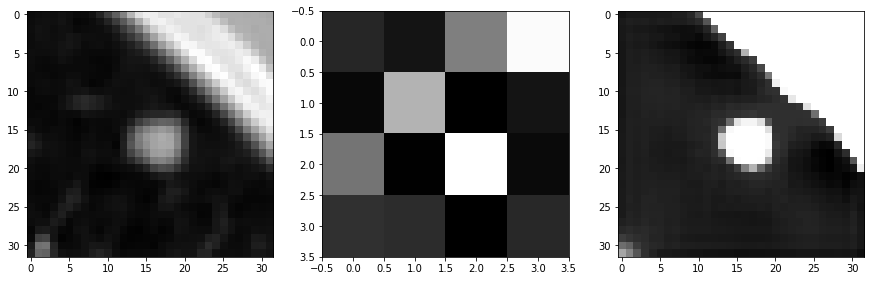

In [22]:
z_index = 3
fig, ax = plt.subplots(ncols=3)
plot_slice(original[0, :], index=z_index, ax=ax[0])
plot_slice(encoder_out[0, :], index=z_index, ax=ax[1])
plot_slice(decoder_out[0, :], index=z_index, ax=ax[2])